# EE495 Programming Exam 3
## Kevin Morales

In [116]:
#--------------Imports-------------------------------
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
import scipy.signal as spsig


def filter395(x,b,a):
    # Implements a direct-form digital filter using difference equations
    
    Ly  = len(x) # length of input and output signals
    La = len(a)  # number of feedback coefficients
    Lb = len(b)  # number of feedforward coefficients
    y = np.zeros(Ly)  # output signal placeholder
    FF = np.zeros(Lb) # Feedforward delay line
    FB = np.zeros(La - 1)  # Feedback delay line excluding a[0]
    
    for i in range(0, Ly, 1):
        
        FF = np.roll(FF,1)    
        FF[0] = x[i]          #FF vector updated with current input
        if i > 0:
            FB = np.roll(FB, 1)
            FB[0] = y[i-1]    #FB vector updated with previous ouptut
        
        y[i] = (np.dot(FF, b) - np.dot(FB, a[1:])) / a[0] # digital filter calculation with difference eq
        
    return y
def ecg(L):
    # ECG generator (from Orfanidis)
    # generates piecewise linear ECG signal of length L 
    # must post-smooth it with an N-point smoother    
    a0 = np.array([0,1,40,1,0,-34,118,-99,0,2,21,2,0,0,0.])
    d0 = np.array([0,27,59,91,131,141,163,185,195,275,307,339,357,390,440.])
    a = a0/a0.max()
    d = (d0*L/d0[14]).round().astype(int)
    d[14] = L
    
    x = np.zeros(L)
    for i in range(0,14):
        m = np.arange(d[i],d[i+1])
        slope = (a[i+1]-a[i])/(d[i+1]-d[i])
        x[m] = a[i] + slope*(m-d[i])
    
    return x
def sg(d,N):    
    M = int((N-1)/2)
    
    S = np.zeros((2*M+1,d+1))
    for m in np.arange(-M,M+1):
        for i in np.arange(0,d+1):
            S[m+M,i] = m**i

    F = np.matmul(np.transpose(S),S)
    B = np.matmul(np.matmul(S,np.linalg.inv(F)),np.transpose(S))
    
    return B
def sgfilt(d,N,x):
    # filtering with length-N order-d SG smoother
    import numpy as np
    
    M = int((N-1)/2)
    L = len(x)
    
    B = sg(d,N)
    
    y = np.zeros(L)
    for i in range(0,M+1):
        y[i] = B[:,i].T@x[0:N]
    
    for n in range(M+1,L-M):
        y[n] = B[:,M].T@x[n-M:n+M+1]
        
    for i in range(0,M+1):
        y[L-M+i-1] = B[:,M+i].T@x[L-N:L+1]
        
    return y

### Problem A - Spectral Analysis I
### Part i - Read in Long Signal

For this first part, we're to read in the signal **signal_long.wav**. This signal is to be read into variable **x**. Once read in, we'll listen to **signal_long.wav**.

In [117]:
fs, x = scipy.io.wavfile.read("signal_long.wav")

#### Discussion

From listening to the wav file, we can hear 4 different tones appear at 4 different times. Each of those tones doesn't sound like a clean single sinusoid being played at a time. This is clear since there are two sinudoids being played in every tone.

### Part a-ii - Define Four Digits 

In this part, we're going to split the signal **x** into 4 different variables labeled **digit#**, where # refers to 1-4. This corresponds to the 4 tones we heard when playing **signal_long.wav**.

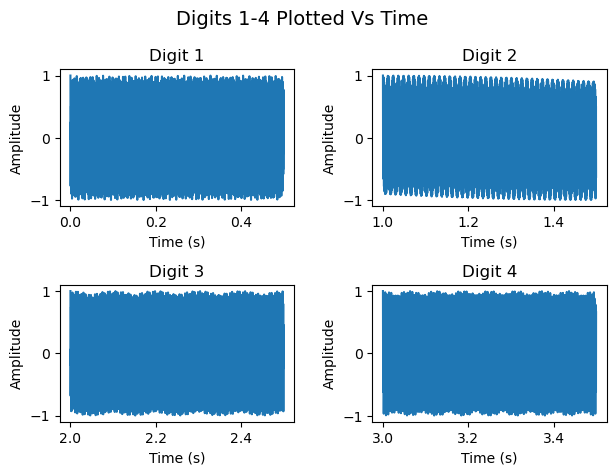

In [118]:
digit1 = x[0:int(fs/2)]
digit2 = x[fs:int(fs*3/2)]
digit3 = x[2*fs:int(fs*5/2)]
digit4 = x[3*fs:int(fs*7/2)]

t = np.arange(x.size) / fs

t1 = t[0:int(fs/2)]
t2 = t[fs:int(fs*3/2)]
t3 = t[2*fs:int(fs*5/2)]
t4 = t[3*fs:int(fs*7/2)]

plt.subplot(2,2,1)
plt.plot(t1,digit1)
plt.title("Digit 1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2,2,2)
plt.plot(t2,digit2)
plt.title("Digit 2")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2,2,3)
plt.plot(t3,digit3)
plt.title("Digit 3")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2,2,4)
plt.plot(t4,digit4)
plt.title("Digit 4")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.suptitle("Digits 1-4 Plotted Vs Time", fontsize=14)

plt.tight_layout()
plt.show()

#### Discussion

The individual plots of the digits can be seen above. **Signal_long.wav** was defined to be the first digit, taking 0.5 seconds, followed by 0.5 seconds of silence. The rest of the digits followed this pattern, and indexing was simply done by using multiples of the sampling frequency to index the right moment where any of the 0.5 seconds ended/started.

### Part a-iii - Choose L and N 

Ideally, we would want to have an infinite number of samples to have the best physical resolution possible. The signal length for any of the digits is 0.5 seconds, which is L = fs/2, or 4000 samples. From the calculations in problem T09-09, the minimum amount of samples to resolve any of the frequencies in this signal is 110. The choice of L I'm taking is 4000. The choice of N is ideally more than L, as to not waste the physical resolution gained from a higher L. The choice of N does have to be a multiple of N. With this in mind, the choice will be 4096. The built in FFT function will pad the remaining 96 samples.

In [119]:
L = 4000
N = 4096

### Part a-iv - Define Four Digit Spectra 

In this part, we're going to compute the spectra of the four different digits. The spectra variables will be defined as **DIGIT#**, where # is 1-4.

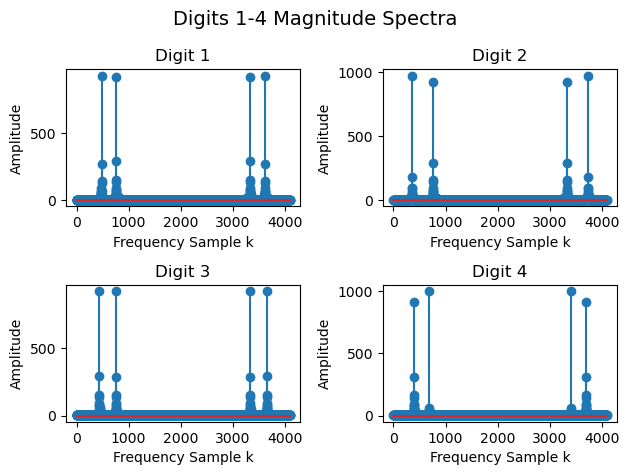

In [120]:
DIGIT1 = np.fft.fft(digit1,N)
DIGIT2 = np.fft.fft(digit2,N)
DIGIT3 = np.fft.fft(digit3,N)
DIGIT4 = np.fft.fft(digit4,N)

k = np.arange(N)

plt.subplot(2,2,1)
plt.stem(k,abs(DIGIT1))
plt.title("Digit 1")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.subplot(2,2,2)
plt.stem(k,abs(DIGIT2))
plt.title("Digit 2")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.subplot(2,2,3)
plt.stem(k,abs(DIGIT3))
plt.title("Digit 3")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.subplot(2,2,4)
plt.stem(k,abs(DIGIT4))
plt.title("Digit 4")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.suptitle("Digits 1-4 Magnitude Spectra", fontsize=14)

plt.tight_layout()
plt.show()

#### Discussion

The 4 different plots can be seen above. Since the fft of the signals show the negative and positive spectra, we know that all signals are made up of 2 different sinusoids.

### Part a-v - Define Digit Peak Indices

In part a-v, we're to index where the peaks seen on the magnitude spectra of the 4 different digits are located.

In [121]:
k11 = np.where(DIGIT1 > 500)[0][0]
k12 = np.where(DIGIT1 > 500)[0][1]
k13 = np.where(DIGIT1 > 500)[0][2]
k14 = np.where(DIGIT1 > 500)[0][3]

k21 = np.where(DIGIT2 > 500)[0][0]
k22 = np.where(DIGIT2 > 500)[0][1]
k23 = np.where(DIGIT2 > 500)[0][2]
k24 = np.where(DIGIT2 > 500)[0][3]

k31 = np.where(DIGIT3 > 500)[0][0]
k32 = np.where(DIGIT3 > 500)[0][1]
k33 = np.where(DIGIT3 > 500)[0][2]
k34 = np.where(DIGIT3 > 500)[0][3]

k41 = np.where(DIGIT4 > 500)[0][0]
k42 = np.where(DIGIT4 > 500)[0][1]
k43 = np.where(DIGIT4 > 500)[0][2]
k44 = np.where(DIGIT4 > 500)[0][3]

print(f"DIGIT 1: index 1: {k11}. index 2: {k12}. index 3: {k13}. index 4: {k14}.")
print(f"DIGIT 2: index 1: {k21}. index 2: {k22}. index 3: {k23}. index 4: {k24}.")
print(f"DIGIT 3: index 1: {k31}. index 2: {k32}. index 3: {k33}. index 4: {k34}.")
print(f"DIGIT 4: index 1: {k41}. index 2: {k42}. index 3: {k43}. index 4: {k44}.")

DIGIT 1: index 1: 482. index 2: 756. index 3: 3340. index 4: 3614.
DIGIT 2: index 1: 357. index 2: 756. index 3: 3340. index 4: 3739.
DIGIT 3: index 1: 436. index 2: 756. index 3: 3340. index 4: 3660.
DIGIT 4: index 1: 394. index 2: 684. index 3: 3412. index 4: 3702.


#### Discussion

From looking at the magnitude spectra of the 4 digits, I found that the peak indices are above 500. Using np.where returns 4 different indices per **DIGIT**, which are the 4 peaks we're looking for. The 16 different indices can be found above.

### Part a-vi - Define Digit Frequencies

For this next part, we're going to convert the frequency indices seen above to a frequency. This is going to be done using the formula: $$k_{xy}=\frac{f_{xy}*N}{f_s}$$.
By doing some algebra, we can program using the formula: $$f_{xy}=\frac{k_{xy}*f_S}{N}$$.

In [122]:
f11 = k11 * fs / N
f12 = k12 * fs / N
f13 = k13 * fs / N
f14 = k14 * fs / N

f21 = k21 * fs / N
f22 = k22 * fs / N
f23 = k23 * fs / N
f24 = k24 * fs / N

f31 = k31 * fs / N
f32 = k32 * fs / N
f33 = k33 * fs / N
f34 = k34 * fs / N

f41 = k41 * fs / N
f42 = k42 * fs / N
f43 = k43 * fs / N
f44 = k44 * fs / N
print("According to the indices k, the 16 frequencies identified are:")
print(f"DIGIT 1: frequency 1: {f11:.2f} Hz. frequency 2: {f12:.2f} Hz. frequency 3: {f13:.2f} Hz. frequency 4: {f14:.2f} Hz.")
print(f"DIGIT 2: frequency 1: {f21:.2f} Hz. frequency 2: {f22:.2f} Hz. frequency 3: {f23:.2f} Hz. frequency 4: {f24:.2f} Hz.")
print(f"DIGIT 3: frequency 1: {f31:.2f} Hz. frequency 2: {f32:.2f} Hz. frequency 3: {f33:.2f} Hz. frequency 4: {f34:.2f} Hz.")
print(f"DIGIT 4: frequency 1: {f41:.2f} Hz. frequency 2: {f42:.2f} Hz. frequency 3: {f43:.2f} Hz. frequency 4: {f44:.2f} Hz.")
print()
print("The 8 correct frequencies are:")
print(f"DIGIT 1: frequency 1: {f11:.2f} Hz. frequency 2: {f12:.2f} Hz")
print(f"DIGIT 2: frequency 1: {f21:.2f} Hz. frequency 2: {f22:.2f} Hz")
print(f"DIGIT 3: frequency 1: {f31:.2f} Hz. frequency 2: {f32:.2f} Hz")
print(f"DIGIT 4: frequency 1: {f41:.2f} Hz. frequency 2: {f42:.2f} Hz")


According to the indices k, the 16 frequencies identified are:
DIGIT 1: frequency 1: 941.41 Hz. frequency 2: 1476.56 Hz. frequency 3: 6523.44 Hz. frequency 4: 7058.59 Hz.
DIGIT 2: frequency 1: 697.27 Hz. frequency 2: 1476.56 Hz. frequency 3: 6523.44 Hz. frequency 4: 7302.73 Hz.
DIGIT 3: frequency 1: 851.56 Hz. frequency 2: 1476.56 Hz. frequency 3: 6523.44 Hz. frequency 4: 7148.44 Hz.
DIGIT 4: frequency 1: 769.53 Hz. frequency 2: 1335.94 Hz. frequency 3: 6664.06 Hz. frequency 4: 7230.47 Hz.

The 8 correct frequencies are:
DIGIT 1: frequency 1: 941.41 Hz. frequency 2: 1476.56 Hz
DIGIT 2: frequency 1: 697.27 Hz. frequency 2: 1476.56 Hz
DIGIT 3: frequency 1: 851.56 Hz. frequency 2: 1476.56 Hz
DIGIT 4: frequency 1: 769.53 Hz. frequency 2: 1335.94 Hz


#### Discussion

The 16 frequencies are printed out above. When accounting for the nyquist interval, we find that frequencies 3 & 4 for all digits are outside of that range; therefore, they can be discarded.

The frequencies are close to the expected frequencies for DTMF, simply rounding will result in the correct frequencies. The reson for the discrepancies is from L and N not capturing the real frequency perfectly, with an infinite L, the DTFT would only show perfect impulses, but you'd need a high enough N to resolve this in the DFT.

### Part a-vii - Manually Define Digits

For this part, we're going to finish the section by identifying the digits dialed using DTMF. Figure 8.1.3 provides a table to identify the digits based on the two frequencies.

In [123]:
print("Digit 1 is: #")
print("Digit 2 is: 3")
print("Digit 3 is: 9")
print("Digit 4 is: 5")

Digit 1 is: #
Digit 2 is: 3
Digit 3 is: 9
Digit 4 is: 5


#### Discussion

The only identification needed was rounding the frequencies printed in part a-vi. 
The sequence was #395. 

<img src="shocked.png" width="200">

The old class number!

### Part B Spectral Analysis II
### Part b-i - Read in Short Signal

In this part, we're going to read in and listen to the wav file **signal_short.wav**. 

In [124]:
fs, x = scipy.io.wavfile.read("signal_short.wav")

#### Discussion

From listening to the wav file **signal_short.wav**, we can hear 4 short tones. I think it's very hard to identify different sinusoids in the short duration of the tones.

### Part b-ii - Define Four Digits

In part b-ii, we're going to extract the 4 bursts of sound from the read in signal **x**. This will be done based on the description of the signal.

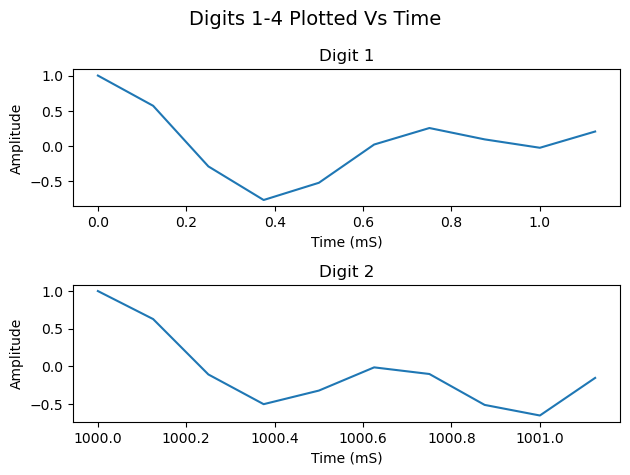

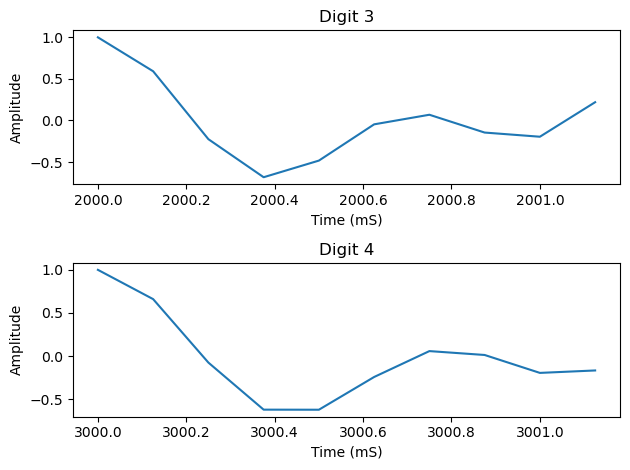

In [125]:
duration = 1.25e-3
digit1 = x[0:int(duration * fs)]
digit2 = x[fs:fs + int(duration*fs)]
digit3 = x[2*fs:2*fs + int(duration*fs)]
digit4 = x[3*fs:3*fs + int(duration*fs)]

t = np.arange(x.size) / fs / 1e-3 # microseconds

t1 = t[0:int(duration*fs)]
t2 = t[fs:fs + int(duration*fs)]
t3 = t[2*fs:2*fs + int(duration*fs)]
t4 = t[3*fs:3*fs + int(duration*fs)]

plt.subplot(2,1,1)
plt.plot(t1,digit1)
plt.title("Digit 1")
plt.xlabel("Time (mS)")
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(t2,digit2)
plt.title("Digit 2")
plt.xlabel("Time (mS)")
plt.ylabel("Amplitude")

plt.suptitle("Digits 1-4 Plotted Vs Time", fontsize=14)

plt.tight_layout()
plt.show()

plt.subplot(2,1,1)
plt.plot(t3,digit3)
plt.title("Digit 3")
plt.xlabel("Time (mS)")
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(t4,digit4)
plt.title("Digit 4")
plt.xlabel("Time (mS)")
plt.ylabel("Amplitude")


plt.tight_layout()
plt.show()

#### Discussion

The plots of the 4 digits can be seen above. From looking at these plots, there is clear evidence of multiple sinusoids, but not clear enough to know how many could be present in each digit.

### Part b-iii - Choose L and N

Now, we're going to define our parameters L and N, and discuss the reason for our choices.

In [126]:
L = duration *fs # 10 samples (1.25 m * 8000)
N = 4096

#### Discussion

The reason I chose L to be 10 is because there are only 10 samples available, choosing anything higher than 10 would result in zero-padding. The reason for my choice of N, 256, is to increase the computational resolution as much as possible. Although my physical resolution is very poor, the higher computational resolution will surely help.

### Part b-iv - Define Four Digit Spectra 

In this part, we're to compute the spectra of the 4 different digits, this should be done using the previously defined L and N.

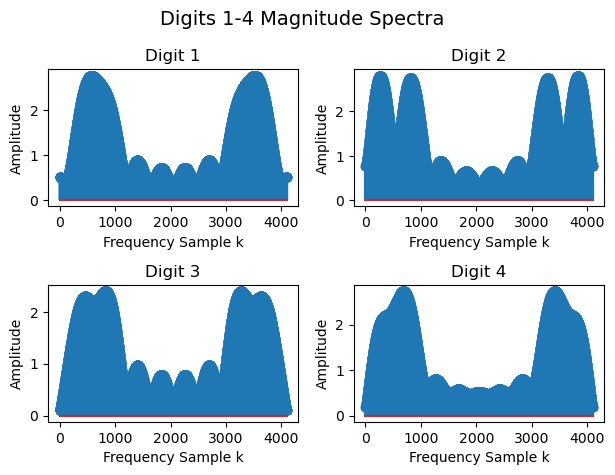

In [127]:
DIGIT1 = np.fft.fft(digit1,N)
DIGIT2 = np.fft.fft(digit2,N)
DIGIT3 = np.fft.fft(digit3,N)
DIGIT4 = np.fft.fft(digit4,N)

k = np.arange(N)

plt.subplot(2,2,1)
plt.stem(k,abs(DIGIT1))
plt.title("Digit 1")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.subplot(2,2,2)
plt.stem(k,abs(DIGIT2))
plt.title("Digit 2")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.subplot(2,2,3)
plt.stem(k,abs(DIGIT3))
plt.title("Digit 3")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.subplot(2,2,4)
plt.stem(k,abs(DIGIT4))
plt.title("Digit 4")
plt.xlabel("Frequency Sample k")
plt.ylabel("Amplitude")

plt.suptitle("Digits 1-4 Magnitude Spectra", fontsize=14)

plt.tight_layout()
plt.show()

##### Discussion

The 4 different magnitude spectra can be seen above. The poor physical resolution leads to the frequencies not looking quite as clean as they did in part a.

### Part b-v - Define Digit Peak Indices

In this part, we're going to find the indexes **k** where the magnitude spectra peaks locally.

In [128]:
k11 = np.where(np.max(DIGIT1) == DIGIT1)[0][0]
k12 = np.where(np.max(DIGIT1[int(k11+1):]) == DIGIT1)[0][0]

k21 = np.where(np.max(DIGIT2[:500]) == DIGIT2)[0][0]
k22 = np.where(np.max(DIGIT2[500:1000]) == DIGIT2)[0][0]
k23 = np.where(np.max(DIGIT2[2000:3600]) == DIGIT2)[0][0]
k24 = np.where(np.max(DIGIT2[3600:]) == DIGIT2)[0][0]

k31 = np.where(np.max(DIGIT3[:650]) == DIGIT3)[0][0]
k32 = np.where(np.max(DIGIT3[650:2000]) == DIGIT3)[0][0]
k33 = np.where(np.max(DIGIT3[2000:3450]) == DIGIT3)[0][0]
k34 = np.where(np.max(DIGIT3[3450:]) == DIGIT3)[0][0]

k41 = np.where(np.max(DIGIT4[:2000]) == DIGIT4)[0][0]
k42 = np.where(np.max(DIGIT4[2000:]) == DIGIT4)[0][0]


print(f"DIGIT 1: index 1: {k11}. index 2: {k12}.")
print(f"DIGIT 2: index 1: {k21}. index 2: {k22}. index 3: {k23}. index 4: {k24}.")
print(f"DIGIT 3: index 1: {k31}. index 2: {k32}. index 3: {k33}. index 4: {k34}.")
print(f"DIGIT 4: index 1: {k41}. index 2: {k42}.")

DIGIT 1: index 1: 582. index 2: 3514.
DIGIT 2: index 1: 289. index 2: 770. index 3: 3326. index 4: 3807.
DIGIT 3: index 1: 488. index 2: 738. index 3: 3358. index 4: 3608.
DIGIT 4: index 1: 626. index 2: 3470.


#### Discussion

From looking and zooming into the plots seen previously, there aren't 4 discernible peaks on digits 1 and 4. The way I found the index of the 4 peaks on the other two digits was by finding where the local minimum between the two peaks was and searching for the maximum using this local minimum as one of the search limits.

### Part b-vi - Define Digit Frequencies

For this next part, we're going to convert the frequency indices seen above to a frequency. This is going to be done using the formula: $$k_{xy}=\frac{f_{xy}*N}{f_s}$$.
By doing some algebra, we can program using the formula: $$f_{xy}=\frac{k_{xy}*f_S}{N}$$.

In [129]:
f11 = k11 * fs / N
f12 = k12 * fs / N

f21 = k21 * fs / N
f22 = k22 * fs / N
f23 = k23 * fs / N
f24 = k24 * fs / N

f31 = k31 * fs / N
f32 = k32 * fs / N
f33 = k33 * fs / N
f34 = k34 * fs / N

f41 = k41 * fs / N
f42 = k42 * fs / N

print("According to the indices k, the 12 frequencies identified are:")
print(f"DIGIT 1: frequency 1: {f11:.2f} Hz. frequency 2: {f12:.2f} Hz.")
print(f"DIGIT 2: frequency 1: {f21:.2f} Hz. frequency 2: {f22:.2f} Hz. frequency 3: {f23:.2f} Hz. frequency 4: {f24:.2f} Hz.")
print(f"DIGIT 3: frequency 1: {f31:.2f} Hz. frequency 2: {f32:.2f} Hz. frequency 3: {f33:.2f} Hz. frequency 4: {f34:.2f} Hz.")
print(f"DIGIT 4: frequency 1: {f41:.2f} Hz. frequency 2: {f42:.2f} Hz.")
print()
print("The 6 correct frequencies are:")
print(f"DIGIT 1: frequency 1: {f11:.2f} Hz")
print(f"DIGIT 2: frequency 1: {f21:.2f} Hz. frequency 2: {f22:.2f} Hz")
print(f"DIGIT 3: frequency 1: {f31:.2f} Hz. frequency 2: {f32:.2f} Hz")
print(f"DIGIT 4: frequency 1: {f41:.2f} Hz.")

According to the indices k, the 12 frequencies identified are:
DIGIT 1: frequency 1: 1136.72 Hz. frequency 2: 6863.28 Hz.
DIGIT 2: frequency 1: 564.45 Hz. frequency 2: 1503.91 Hz. frequency 3: 6496.09 Hz. frequency 4: 7435.55 Hz.
DIGIT 3: frequency 1: 953.12 Hz. frequency 2: 1441.41 Hz. frequency 3: 6558.59 Hz. frequency 4: 7046.88 Hz.
DIGIT 4: frequency 1: 1222.66 Hz. frequency 2: 6777.34 Hz.

The 6 correct frequencies are:
DIGIT 1: frequency 1: 1136.72 Hz
DIGIT 2: frequency 1: 564.45 Hz. frequency 2: 1503.91 Hz
DIGIT 3: frequency 1: 953.12 Hz. frequency 2: 1441.41 Hz
DIGIT 4: frequency 1: 1222.66 Hz.


#### Discussion

The resulting frequencies can be seen above. Unlike part a, these frequencies show a lot of error from the desired frequencies designated by **figure 8.1.3**. The source of this difference is the poor physical resolution in combination with our choice of N resulting in the peak seen on the magnitude spectra not aligning with the real frequency of the sinusoid in the signal. The source of the similarities is most likely because they're the exact same tones, just cut from 0.5 seconds to 0.00125 seconds.

### Part b-vii - Manually Define Digits 

For this final part, we're going to interpret the frequencies seen above into digits based on **figure 8.1.3**. 

In [130]:
print("Digit 1 could be: 1, 4, 7, or *")
print("Digit 2 is: 3")
print("Digit 3 is: #")
print("Digit 4 could be: 1, 4, 7, or *")

Digit 1 could be: 1, 4, 7, or *
Digit 2 is: 3
Digit 3 is: #
Digit 4 could be: 1, 4, 7, or *


#### Discussion

The digits found can be seen above. As you can see, digits 1 and 4 don't have set values, as the frequencies we tried to identify didn't have enough physical resolution. A lot of these frequencies did have to be interpreted, as there was substantial error between the measured freqeuncy and the desired DTMF frequency. The interpretation was done by finding the nearest frequency in the DTMF table found on **figure 8.1.3**.

The results in this section were different from in section a. This can be attributted to the very small number of samples provided, which decreased the physical resolution so much that even having a ridiculously high N, will still not make the peaks of the DFT show up at the right frequnecies. No matter how high we crank up N, we can't resolve the right frequencies of the signal **signal_short.wav**

### Part C - FIR Filter Design
### Part c-i - Specify Filter Parameters 

In this first part, we're going to use some given characteristics of an FIR to build out the full set of the filter characteristics which are: $delta_{pass}, A_{pass}, delta_{stop},  A_{stop}, f_{pass}, w_{pass}, f_{stop}, w_{stop}$.

In [131]:
delta_pass = 0.1
Apass = 20*np.log10((1+delta_pass) / (1-delta_pass))
Astop = 100 # dB
delta_stop = 10 ** (-Astop / 20)
fpass = 941
fstop = 1209
fs = 8e3
wpass = fpass / fs *2*np.pi
wstop = fstop / fs *2*np.pi
delta_f = fstop - fpass

print(f"delta_pass = {delta_pass}")
print(f"Apass = {Apass:.3} dB")
print(f"delta_stop = {delta_stop}")
print(f"Astop = {Astop} dB")
print(f"f_pass = {fpass} Hz")
print(f"w_pass = {wpass:.3} rad/s")
print(f"f_stop = {fstop} Hz")
print(f"w_stop = {wstop:.3} rad/s")
print(f"delta_f = {delta_f} Hz")

delta_pass = 0.1
Apass = 1.74 dB
delta_stop = 1e-05
Astop = 100 dB
f_pass = 941 Hz
w_pass = 0.739 rad/s
f_stop = 1209 Hz
w_stop = 0.95 rad/s
delta_f = 268 Hz


#### Discussion

The 8 different FIR filter parameters that were requested can be seen above. Additionally $delta_f$ can be seen as well. 

### Part c-ii - Choose Window Type

Based on the stop-band attenuation of 100 dB, we'll be needing to use a kaiser window. The rectangular window provides very poor performance in the stop-bnd attenuation, with the first sidelobe only being reduced by 13dB. The hamming window provides bettwer performance with a 40 dB attenuation, but we'll be needing 100 dB.

### Part c-iii - Combine Window Length and Parameters

Now we'll be finding the kaiser window length, and it's relevant parameter alpha. Alpha is the shaping parameter.

In [132]:
delta = min([delta_pass, delta_stop])
A = -20*np.log10(delta)

delta_w_norm = (delta_f) / fs * 2 
N, alpha = spsig.kaiserord(A, delta_w_norm)


print(f"Kaiser window length N: {N}. Shape parameter alpha: {alpha}.")

Kaiser window length N: 193. Shape parameter alpha: 10.06126.


#### Discussion

The window shape chosen was the kaiser window. The relevant parameters of this window are alpha, the shape parameter, and N, the filter order. The two parameters can be seen above.

### Part c-iv - Passband Response

Now, we're going to plot the magnitude response of the filter we determined in linear magnitude vs frequency. In this part, we're going to focus on the pass-band response.

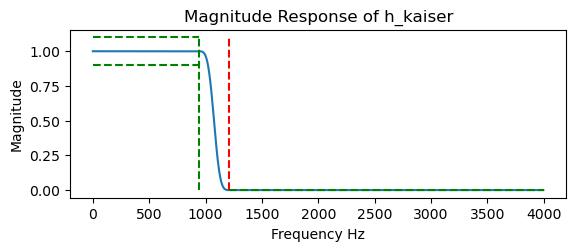

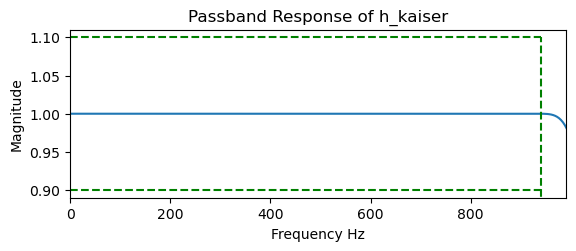

In [133]:
wc_norm = 2*np.pi * ((fstop + fpass) / 2) / fs / np.pi

h_kaiser = spsig.firwin(N, wc_norm, window = ('kaiser',alpha))

w, h = spsig.freqz(h_kaiser1, 1, 1024)
f = w * fs /( 2* np.pi)

plt.subplot(2,1,1)
plt.plot(f,abs(h))
plt.title("Magnitude Response of h_kaiser")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude")

plt.plot([fpass, fpass],[0,1+delta_pass],'g--')
plt.plot([fstop, fstop],[0,1+delta_pass],'r--')
plt.plot([0,fpass], [1+delta_pass, 1+delta_pass], 'g--')
plt.plot([0,fpass],[1-delta_pass, 1-delta_pass],'g--')
plt.plot([fstop,fs/2],[delta_stop,delta_stop],'g--')

plt.show()

plt.subplot(2,1,2)
plt.plot(f,abs(h))
plt.title("Passband Response of h_kaiser")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude")


plt.plot([fpass, fpass],[0,1+delta_pass],'g--')
plt.plot([0,fpass], [1+delta_pass, 1+delta_pass], 'g--')
plt.plot([0,fpass],[1-delta_pass, 1-delta_pass],'g--')
plt.axis([0,fpass+50,0.89, 1.11])
plt.show()

#### Discussion

The requested plots of the magnitude response and a zoom in to the pass-band response can be seen above. From looking at this, the filter clearly meets the passband requirements, as the response never crosses outside the green lines. These green lines mark 1±delta_pass, and fpass.

### Part c-v -Stopband Response

Now, we're going to plot the magnitude response of the filter response in dB magnitude instead. This time, we'll look more into the response of the filter in the stop-band.

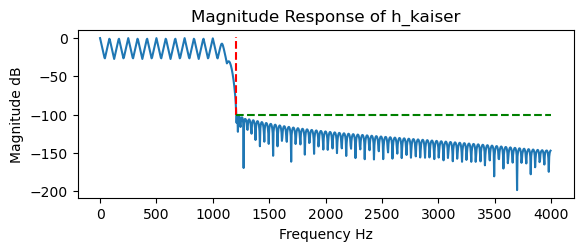

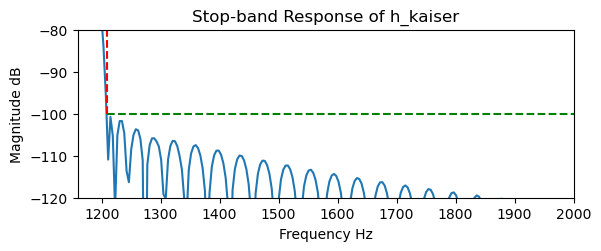

In [134]:
plt.subplot(2,1,1)
plt.plot(f,-abs(20*np.log10(h)))
plt.title("Magnitude Response of h_kaiser")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude dB")

plt.plot([fstop, fstop],[-100,1],'r--')
plt.plot([fstop,fs/2],[0-Astop,0-Astop],'g--')
plt.show()

plt.subplot(2,1,2)
plt.plot(f,- abs(20*np.log10(h)))
plt.title("Stop-band Response of h_kaiser")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude dB")

plt.plot([fstop, fstop],[-100,0],'r--')
plt.plot([fstop,fs/2],[0-Astop,0-Astop],'g--')
plt.axis([fstop-50, fs/4, -120, -80])
plt.show()

#### Discussion

The Magnitude response in dB vs frequency can be seen above. By zooming into the stop-band, we can see that the response of the stop-band is behaving as expected, any frequency in the high range of DTMF, which starts at 1209, is attenuated to less than 100 dB.

### Part c-vi - Filtered Signal

Using the filter we designed, we're going to filter the signal **singal_long.wav**. Once we've filtered the signal, we're to write it out to a new wav file, listen to it and analyze it.

In [135]:
fs, x = scipy.io.wavfile.read("signal_long.wav")

y_FIR = spsig.lfilter(h_kaiser,1,x) 
y_FIR = y_FIR / y_FIR.max() * 0.99

scipy.io.wavfile.write('y_FIR.wav', int(fs), y_FIR)

#### Discussion

The output sounds as expected, there are still 3 tones, since all 4 digits include one sinusoid in the pass-band. Additionally the tones sound more clean, like there's only one sinusoid in each tone. This makes sense as the higher frequency DTMF sinusoids were attenuated to an imperceptible level

### Part D - IIR Filter Design
### Part d-i - Compute Order and 3-dB Frequency

Now, we're to design a butterworth filter that will meet the same specifications as before, and for this section, we're to find the filter order and 3-dB frequency.

In [136]:

wp_norm = fpass / fs * 2
ws_norm = fstop / fs * 2

epsilon_pass = np.sqrt(10 ** (Apass/10) - 1)
epsilon_stop = np.sqrt(10 ** (Astop/10) - 1)

Nbr, W0r = spsig.buttord(wp_norm, ws_norm, Apass, Astop)

print(f"Filter order N = {Nbr}")
print(f"Normalized 3-dB frequency = {W0r:.4}, {W0r * fs /2:.4} Hz")
print(W0r)

Filter order N = 42
Normalized 3-dB frequency = 0.2371, 948.2 Hz
0.23705657055044188


#### Discussion

From the printouts above, we can see that the filter order is only 42, which is much less than the FIR implementation. The 3-dB frequency is 948.2 Hz, which meets the requirement of 941 being in the passband, and 1209 being in the stop-band.

### Part d-ii - Passband Response

Now, we're going to plot the magnitude response of the butterworth filter implementation, and focus on the pass-band.

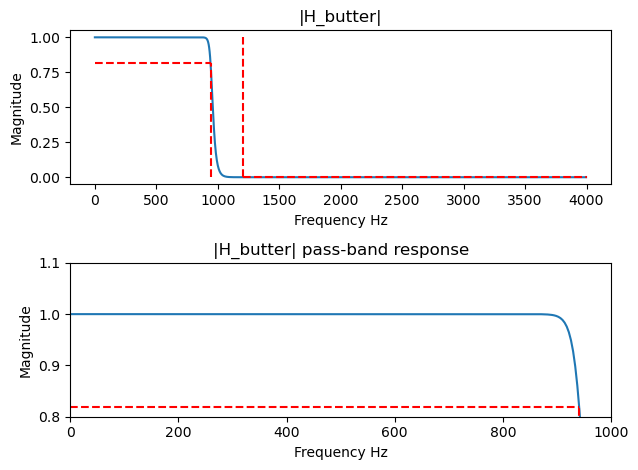

In [137]:
sos = spsig.butter(Nbr, W0r, output='sos')
b,a = spsig.butter(Nbr, W0r)
wb, hb = spsig.sosfreqz(sos, worN=1024)

fb = wb * fs /( 2* np.pi)

plt.subplot(2,1,1)
plt.plot(fb,abs(hb))
plt.title("|H_butter|")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude")

plt.plot([0,fpass],[np.sqrt(1/(1+(epsilon_pass**2))),np.sqrt(1/(1+(epsilon_pass**2)))],'r--')
plt.plot([fpass,fpass],[0,np.sqrt(1/(1+(epsilon_pass**2)))],'r--')
plt.plot([fstop,fs/2],[np.sqrt(1/(1+(epsilon_stop**2))),np.sqrt(1/(1+(epsilon_stop**2)))],'r--')
plt.plot([fstop,fstop],[np.sqrt(1/(1+(epsilon_stop**2))), 1],'r--')

plt.subplot(2,1,2)
plt.plot(fb,abs(hb))
plt.title("|H_butter| pass-band response")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude")
plt.axis([0,1000,0.8,1.1])

plt.plot([0,fpass],[np.sqrt(1/(1+(epsilon_pass**2))),np.sqrt(1/(1+(epsilon_pass**2)))],'r--')
plt.plot([fpass,fpass],[0,np.sqrt(1/(1+(epsilon_pass**2)))],'r--')

plt.tight_layout()
plt.show()

#### Discussion

On the first attempt the frequency response of the filter looked incorrect. Through research on proper implementation of a high order IIR filter, I found that using spsig.butter(N,W0,output='sos'), would return a second order section implementation of the IIR filter.

By zooming in, we can find, that the pass-band response is desired, and there is no crossing into the no-pass zones.

### Part d-iii - Stopband Response

Now, we're to plot the magnitude response in dB vs frequency, and analyze the behavior in the stop-band.

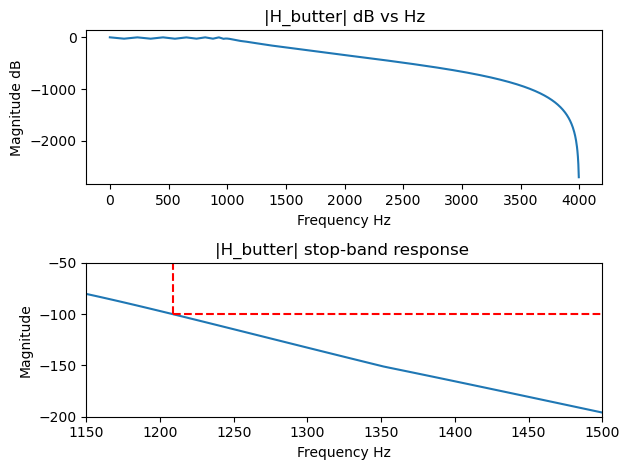

In [138]:
plt.subplot(2,1,1)
plt.plot(fb,-abs(20*np.log10(hb)))
plt.title("|H_butter| dB vs Hz")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude dB")

plt.subplot(2,1,2)
plt.plot(fb,-abs(20*np.log10(hb)))
plt.title("|H_butter| stop-band response ")
plt.xlabel("Frequency Hz")
plt.ylabel("Magnitude")
plt.axis([1150,1500,-200,-50])

plt.plot([fstop,fs/2],[-100,-100],'r--')
plt.plot([fstop,fstop],[-100,0],'r--')

plt.tight_layout()
plt.show()

#### Discussion

As we can see, from the zoomed in stop-bamd response, we can see that anything past fstop, which is 1209 Hz, is attenuated below 100 dB. This means, that the filter met our desired stop-band specifications.

### Part d-iv - Filtered Signal

Finally, we're going to implement the butterworth IIR filter we designed to filter **signal_long.wav**, and write the result into a new sound file: **y_IIR.wav**. I'm expecting to hear the same result as the FIR filter.

In [139]:
fs, x = scipy.io.wavfile.read("signal_long.wav")

y_IIR = spsig.lfilter(b,a,x) 
y_IIR = y_IIR / y_IIR.max() * 0.99

scipy.io.wavfile.write('y_IIR.wav', int(fs), y_FIR)

#### Discussion

The output matched expectations. The wav file sounds exactly the same as the FIR implementation in my ears. This makes sense, as the specifications were met. The high frequency sinusoids should be filtered out, while keeping the low frequency sinusoids. This means we should still hear the 4 tones, but only one sinusoid per tone.
